# Full Example with Bernoulli Beams

In [313]:
%matplotlib inline


In [314]:
from linkeddeepdict import LinkedDeepDict


In [315]:
# units in kN and cm

Lx, Ly, Lz = 100., 15., 15.  # size of the grid
nx, ny, nz = 4, 2, 2  # desity of the grid

d = 1.2  # outer diameter of the tube
t = 0.4  # thickness of the tube

Ex = 21000.0
nu = 0.25
fy = 35.0

loads = LinkedDeepDict()

# load case 1
loads['LC1', 'position'] = [Lx, 0, 0]
loads['LC1', 'value'] = [0, 0, 2.0, 0, 0, 0]

# load case 2
loads['LC2', 'position'] = [Lx, Ly/2, 0]
loads['LC2', 'value'] = [0, 2.0, 0, 0, 0, 0]

# load case 3
loads['LC3', 'position'] = [Lx, -Ly/2, 0]
loads['LC3', 'value'] = [0, -2.0, 0, 0, 0, 0]

filename = 'bernoulli_full_example'


In [316]:
from linkeddeepdict import LinkedDeepDict
from sigmaepsilon.solid.fourier.latex import expr_to_ltx, expr_to_ltx_breqn
from sigmaepsilon.solid.fourier.symtools import inv_sym_3x3
from time import time

import sympy as sy
from sympy import symbols, Function, diff, Matrix, MatMul, \
    integrate, Symbol, sin, cos, pi, simplify
import pylatex as pltx
from pylatex import Command, NoEscape, Tabular, NewPage
import latexdocs
from latexdocs import Document, Table, TableX, Image
from latexdocs.utils import floatformatter
from latexdocs.preamble import append_packages, append_cover, __default__packages__
from copy import copy
import matplotlib.pyplot as plt


f2s = floatformatter(sig=4)


class MyDocument(Document):

    def init_doc(self, **kwargs) -> pltx.Document:
        """
        Initializes the document. This covers appending packages
        and the preamble.

        """
        dcls = self.__class__.documentclass
        kwargs['documentclass'] = kwargs.get('documentclass', dcls)
        #self._geometry_options["includeheadfoot"] = True
        kwargs['geometry_options'] = self._geometry_options
        doc = pltx.Document(**kwargs)
        packages = copy(__default__packages__)
        doc = append_packages(doc, packages)
        doc = append_cover(doc, self._title, self._author, self._date)
        return doc


title = "Linear Analysis of Bernoulli Beams"
doc = MyDocument(title=title, author='Bence Balogh', date=False)
doc.append(NoEscape(r'\maketitle'))
doc.append(NoEscape(r'\hrulefill'))

# The height of each row is set to 1.5 relative to its default height.
doc.append(NoEscape(r'\renewcommand{\arraystretch}{1.2}'))

# The space between the text and the left/right border of its
# containing cell is set to 18pt with this command. Again,
# you may use other units if needed.
doc.append(NoEscape(r'\setlength{\tabcolsep}{6pt}'))

summary = LinkedDeepDict()


In [317]:
from polymesh.space import StandardFrame, PointCloud
from polymesh.grid import gridH8 as grid
from polymesh.topo.tr import H8_to_L2
import numpy as np

gridparams = {
    'size': (Lx, Ly, Lz),
    'shape': (nx, ny, nz),
    'origo': (0, 0, 0),
    'start': 0
}

coords, topo = grid(**gridparams)
coords, topo = H8_to_L2(coords, topo)

GlobalFrame = StandardFrame(dim=3)

points = PointCloud(coords, frame=GlobalFrame).centralize()
dx = - np.array([points[:, 0].min(), 0., 0.])
points.move(dx)
coords = points.show()


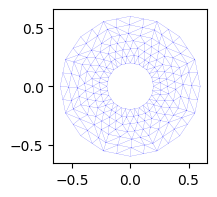

In [318]:
from sigmaepsilon.solid import BeamSection
from linkeddeepdict.tools import getallfromkwargs
from polymesh.tri.trimesh import triangulate
from polymesh.topo.tr import T6_to_T3
import matplotlib.pyplot as plt
from dewloosh.mpl import triplot

section = BeamSection('CHS', d=d, t=t, n=16)
section.calculate_section_properties()
section_props = section.section_properties
A, Ix, Iy, Iz = getallfromkwargs(['A', 'Ix', 'Iy', 'Iz'], **section_props)

G = Ex / (2 * (1 + nu))
Hooke = np.array([
    [Ex*A, 0, 0, 0],
    [0, G*Ix, 0, 0],
    [0, 0, Ex*Iy, 0],
    [0, 0, 0, Ex*Iz]
])

scoords, stopo = section.coords(), section.topology()
path = np.array([[0, 5, 4], [5, 1, 3], [3, 2, 4], [5, 3, 4]], dtype=int)
scoords, stopo = T6_to_T3(scoords, stopo, path=path)
triobj = triangulate(points=scoords, triangles=stopo)[-1]
fig, ax = plt.subplots(figsize=(7, 2))
triplot(triobj, fig=fig, ax=ax, lw=0.1)

fig.savefig("cross section.pdf")
caption = "Mesh of the cross section."
img = Image("cross section.pdf", position='h!',
            width='full', caption=caption)
doc['Input Data'].append(img)

columns = ['E', r'$\nu$', 'A', r'$I_x$', r'$I_y$', r'$I_z$']
columns = list(map(NoEscape, columns))
values = [Ex, nu, A, Ix, Iy, Iz]
values = list(map(f2s.format, values))

table = Table('| c c | c c c c |', 'h!', caption="Section properties.",
              label="table:tbl-section")
table.add_hline()
table.add_row(columns)
table.add_hline()
table.add_hline()
table.add_row(values)
table.add_hline()
doc['Input Data'].append(table)


In [319]:
doc['Input Data'].append(NewPage())


## Results

### Linear Solution

In [320]:
from sigmaepsilon.solid import Structure, LineMesh, PointData
from polymesh.space import StandardFrame, frames_of_lines
from polymesh.space.utils import index_of_closest_point
from sigmaepsilon.solid.fem.cells import B2 as Beam

# space
GlobalFrame = StandardFrame(dim=3)

# essential boundary conditions
ebcinds = np.where(coords[:, 0] < 1e-12)[0]
fixity = np.zeros((coords.shape[0], 6)).astype(bool)
fixity[ebcinds, :] = True

# natural boundary conditions
nLoadCase = len(loads)
nodal_loads = np.zeros((coords.shape[0], 6, nLoadCase))
for iLC, key in enumerate(loads):
    x = loads[key]['position']
    f = loads[key]['value']
    iN = index_of_closest_point(coords, np.array(x))
    loads[key]['node'] = iN
    nodal_loads[iN, :, iLC] = f

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=nodal_loads, fixity=fixity)

# celldata
frames = frames_of_lines(coords, topo)
cd = Beam(topo=topo, frames=frames)

# set up mesh and structure
mesh = LineMesh(pd, cd, model=Hooke, frame=GlobalFrame)
structure = Structure(mesh=mesh)


In [321]:
structure.linsolve(summary=True)
dt = structure.summary['linsolve']['proc']['time']
dofsol = structure.nodal_dof_solution()
dofsol.shape


(45, 6, 3)

In [322]:
columns = ['index', 'name', r'$U_x$', r'$U_y$', r'$U_z$',
           r'$\varphi_x$', r'$\varphi_y$', r'$\varphi_z$']
columns = list(map(NoEscape, columns))
rows = []
for iLC, key in enumerate(loads):
    iN = loads[key]['node']
    u = dofsol[iN, :, iLC]
    row = [iLC, key] + list(map(f2s.format, u))
    rows.append(row)

caption = "DOF solutions of loaded nodes for each load case."
table = Table('| c c | c c c c c c |', 'h!', caption=caption,
              label="table:tbl-dofsol")
table.add_hline()
table.add_row(columns)
table.add_hline()
table.add_hline()
table.add_rows(rows)
table.add_hline()
doc['Results'].append(table)


### Postprocessing

Internal forces, stresses and utilization for all members

In [323]:
from sigmaepsilon.solid.material.utils import HMH_3d_v

evaluation_points = [-1., 0., 1.]

# forces
forces_all = structure.internal_forces(points=evaluation_points)

# stresses
stresses_all = section.calculate_stresses(forces_all)

# utilizations
nE, nPx, nPyz, nS, nRHS = stresses_all.shape
stresses_all = np.moveaxis(stresses_all, -1, -2)
stresses_all = np.reshape(stresses_all, (nE * nPx * nPyz * nRHS, nS))
utils_all = HMH_3d_v(*[stresses_all[:, i] for i in range(6)]) / fy
utils_all = np.reshape(utils_all, (nE, nPx, nPyz, nRHS))
stresses_all = np.reshape(stresses_all, (nE, nPx, nPyz, nRHS, nS))
stresses_all = np.moveaxis(stresses_all, -1, -2)

In [324]:
forces_all.shape, stresses_all.shape, utils_all.shape

((96, 3, 6, 3), (96, 3, 224, 6, 3), (96, 3, 224, 3))

Ranges for stresses and utilizations

In [325]:
from neumann.array import minmax

ranges = [minmax(stresses_all[:, :, :, i, :]) for i in range(6)]
ranges.append((0.0, utils_all.max()))
ranges = np.array(ranges)


Find points with high utilizations

In [326]:
util_max = utils_all.max()
util_tol = min(util_max, 1.0) * 0.9
iE, iPx, iPyz, iRHS = np.nonzero(utils_all > util_tol)
uiE, i = np.unique(iE, return_index=True)
iE, iPx, iPyz, iRHS = iE[i], iPx[i], iPyz[i], iRHS[i]


Plot critical results

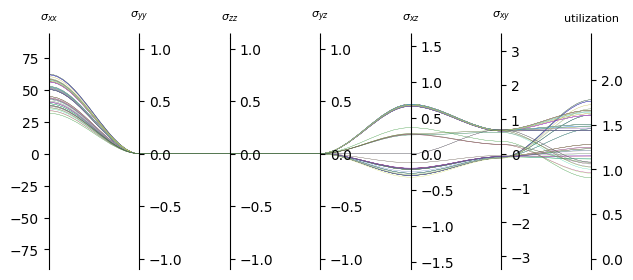

In [327]:
from neumann.array import atleast2d
from dewloosh.mpl import parallel

labels = ['$\sigma_{xx}$', '$\sigma_{yy}$', '$\sigma_{zz}$', '$\sigma_{yz}$',
          '$\sigma_{xz}$', '$\sigma_{xy}$', 'utilization']

forces_critical = forces_all[iE, iPx, :, iRHS]
stresses_critical = stresses_all[iE, iPx, iPyz, :, iRHS]
utils_critical = utils_all[iE, iPx, iPyz, iRHS]
data = np.hstack([stresses_critical, atleast2d(utils_critical, back=True)])
colors = np.random.rand(len(data), 3)

fig = parallel(data, labels=labels, padding=0.05, lw=0.2,
               colors=colors, figsize=(7, 3), ranges=ranges)

plt.savefig("bernoulli_B2_parallel_1.pdf")

caption = "Stresses for several points."
img = Image("bernoulli_B2_parallel_1.pdf", position='h!',
            width='full', caption=caption)

doc['Results'].append(img)


Find points with highest utilizations

In [328]:
forces_critical.shape, stresses_critical.shape, utils_critical.shape

((84, 6), (84, 6), (84,))

In [329]:
i_critical = np.where(utils_critical == utils_critical.max())[0][0]
iE_critical, iPx_critical, iPyz_critical, iRHS_critical = \
    iE[i_critical], iPx[i_critical], iPyz[i_critical], iRHS[i_critical]
#forces_max = forcesi_critical[i_critical]
#stresses_max = stressesi_critical[i_critical]

txt = r"The maximum utilization occurs at element ${}$, from load case ${}$ at location ${}$."
loc_critical = f2s.format(evaluation_points[iPx_critical])
content = NoEscape(txt.format(iE_critical, iRHS_critical, loc_critical))
doc['Results'].append(content)

Plot results

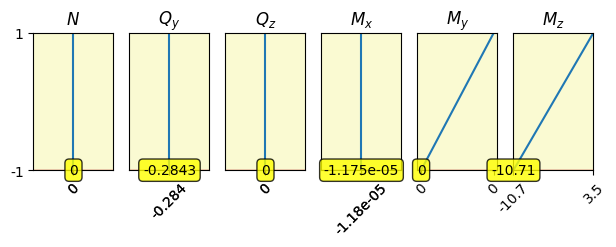

In [330]:
import matplotlib.pyplot as plt
from dewloosh.mpl import aligned_parallel

data = forces_all[iE_critical, :, :, iRHS_critical]  # (3, 6)
labels = ['$N$', '$Q_y$', '$Q_z$', '$M_x$', '$M_y$', '$M_z$']
fig = aligned_parallel(data, evaluation_points, labels=labels, slider=False,
                       xticksrotation=45, figsize=(7, 2.5), yticks=[-1, 1], 
                       y=evaluation_points[iPx_critical])
fig.subplots_adjust(left=0.1, bottom=0.3, right=0.9, top=0.85)

fig.savefig("bernoulli_B2_parallel_2.pdf")

caption = "Internal forces for element {}.".format(iE_critical)
img = Image("bernoulli_B2_parallel_2.pdf", position='h!',
            width='full', caption=caption)

doc['Results'].append(img)


Calculate stresses from internal forces

In [331]:
forces_critical = forces_all[iE_critical, iPx_critical, :, iRHS_critical]
section_stresses_critical = section.calculate_stresses(forces_critical)
section_stresses_critical.shape


(224, 6)

In [332]:
from sigmaepsilon.solid.material.utils import HMH_3d_v

section_utils = HMH_3d_v(*[section_stresses_critical[:, i] for i in range(6)]) / fy
section_utils.shape


(224,)

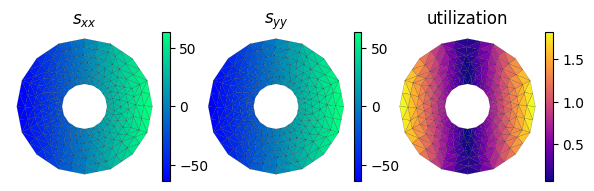

In [333]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 2))
scoords, stopo = section.coords(), section.topology()
path = np.array([[0, 5, 4], [5, 1, 3], [3, 2, 4], [5, 3, 4]], dtype=int)
scoords, stopo = T6_to_T3(scoords, stopo, path=path)
triobj = triangulate(points=scoords, triangles=stopo)[-1]

ax1.set_title('$s_{xx}$')
triplot(triobj, data=section_stresses_critical[:, 0], 
        fig=fig, ax=ax1, axis='off', lw=0.1)

ax2.set_title('$s_{yy}$')
triplot(triobj, data=section_stresses_critical[:, 0], 
        fig=fig, ax=ax2, axis='off', lw=0.1)

ax3.set_title('utilization')
triplot(triobj, data=section_utils, fig=fig, ax=ax3, axis='off', 
        lw=0.1, cmap='plasma')

fig.savefig("cross section results.pdf")

caption = "Results of a cross section."
img = Image("cross section results.pdf", position='h!',
            width='full', caption=caption)

doc['Results'].append(img)

In [334]:
from pylatex import LongTable, MultiColumn, NewPage

columns = ['index', r'$U_x$', r'$U_y$', r'$U_z$',
           r'$\varphi_x$', r'$\varphi_y$', r'$\varphi_z$']
columns = list(map(NoEscape, columns))

data_table = LongTable("| c | c c c c c c |")

data_table.add_hline()
data_table.add_row(columns)
data_table.add_hline()
data_table.end_table_header()
data_table.add_hline()
data_table.add_row((MultiColumn(7, align='r',
                    data='... continued on next page'),))
data_table.end_table_footer()
data_table.add_hline()
data_table.end_table_last_footer()

for i in range(dofsol.shape[0]):
    u = dofsol[i, :, 0]
    row = [i] + list(map(f2s.format, u))
    data_table.add_row(row)
    
doc['Results'].append(NewPage())
doc['Appendix'].append(data_table)


In [335]:
#doc.build().generate_pdf(filename, compiler='pdflatex')


In [336]:
doc.build().generate_tex(filename)
